In [1]:
import os
import sys
import pandas as pd
import numpy as np
import neptune
from neptune.utils import stringify_unsupported
from utils_neptune import start_neptune_run

In [3]:

import sklearn
print('sklearn version: ', sklearn.__version__)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

sklearn version:  1.3.2


In [2]:
data_dir ='/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/March_22_Data'

In [15]:
X_train = pd.read_csv(os.path.join(data_dir, 'X_finetune_train.csv'),index_col=0)
y_train = pd.read_csv(os.path.join(data_dir, 'y_finetune_train.csv'),index_col=0)
X_val = pd.read_csv(os.path.join(data_dir, 'X_finetune_val.csv'), index_col=0)
y_val = pd.read_csv(os.path.join(data_dir, 'y_finetune_val.csv'), index_col=0)

In [16]:
y_val = y_val['MSKCC BINARY']
y_train = y_train['MSKCC BINARY']

# drop the nans
y_val = y_val.dropna()
X_val = X_val.loc[y_val.index]
y_train = y_train.dropna()
X_train = X_train.loc[y_train.index]

In [82]:
y_train.shape

(230,)

In [81]:
y_val.shape

(82,)

In [26]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_prob = lr.predict_proba(X_val)[:,1]


train_roc_auc = roc_auc_score(y_train, lr.predict_proba(X_train)[:,1], average='micro')
val_roc_auc = roc_auc_score(y_val, y_prob, average='micro')

run, _ = start_neptune_run(with_run_id=None,tags=['v3.1','classical'])
run['finetune_mkscc/kwargs/model_kind'] ='LogisticRegression'
run['finetune_mkscc/eval/train/Binary_MSKCC/AUROC (micro)'] = train_roc_auc
run['finetune_mkscc/eval/val/Binary_MSKCC/AUROC (micro)'] = val_roc_auc

run.stop()

In [27]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_prob = rf.predict_proba(X_val)[:,1]

train_roc_auc = roc_auc_score(y_train, rf.predict_proba(X_train)[:,1], average='micro')
val_roc_auc = roc_auc_score(y_val, y_prob, average='micro')

run, _ = start_neptune_run(with_run_id=None,tags=['v3.1','classical'])
run['finetune_mkscc/kwargs/model_kind'] ='RandomForestClassifier'
run['finetune_mkscc/eval/train/Binary_MSKCC/AUROC (micro)'] = train_roc_auc
run['finetune_mkscc/eval/val/Binary_MSKCC/AUROC (micro)'] = val_roc_auc

run.stop()


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/e/RCC-1426
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/revivemed/RCC/e/RCC-1426/metadata


In [28]:
svc = SVC(probability=True)
svc.fit(X_train, y_train)
y_prob = svc.predict_proba(X_val)[:,1]

train_roc_auc = roc_auc_score(y_train, svc.predict_proba(X_train)[:,1], average='micro')
val_roc_auc = roc_auc_score(y_val, y_prob, average='micro')

run, _ = start_neptune_run(with_run_id=None,tags=['v3.1','classical'])
run['finetune_mkscc/kwargs/model_kind'] ='SVC'
run['finetune_mkscc/eval/train/Binary_MSKCC/AUROC (micro)'] = train_roc_auc
run['finetune_mkscc/eval/val/Binary_MSKCC/AUROC (micro)'] = val_roc_auc

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/e/RCC-1427
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/revivemed/RCC/e/RCC-1427/metadata


## Run Evaluation

In [4]:
NEPTUNE_API_TOKEN = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMGM5ZDhiMy1kOTlhLTRlMTAtOGFlYy1hOTQzMDE1YjZlNjcifQ=='


In [5]:
encoder_kind = 'AE'
project = neptune.init_project(
    project='revivemed/RCC',
    mode="read-only",
    api_token=NEPTUNE_API_TOKEN
)

runs_table_df = project.fetch_runs_table(tag=['v3.1'],state='inactive').to_pandas()

#drop the failed runs
runs_table_df = runs_table_df[~runs_table_df['sys/failed']].copy()

#filter by encoder_kind
runs_table_df = runs_table_df[runs_table_df['pretrain/kwargs/encoder_kind'] == encoder_kind].copy()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/


Fetching table...: 0 [00:00, ?/s]

[neptune] [warning] NeptuneWarning: Date parsing failed. The date format is incorrect. Returning as string instead of datetime.


In [11]:
randinit_cols = [x for x in runs_table_df.columns if 'randinit_mkscc_' in x]
randinit_cols = [x for x in randinit_cols if 'AUROC' in x]
df = runs_table_df[randinit_cols].copy()

# drop nans
df.dropna(subset=['randinit_mkscc_1/train/train/epoch/Binary_MSKCC/AUROC (micro)'],inplace=True)

In [12]:
df

,randinit_mkscc_0/eval/test/Binary_MSKCC/AUROC (micro),randinit_mkscc_0/eval/train/Binary_MSKCC/AUROC (micro),randinit_mkscc_0/eval/val/Binary_MSKCC/AUROC (micro),randinit_mkscc_0/train/train/epoch/Binary_MSKCC/AUROC (micro),randinit_mkscc_1/eval/test/Binary_MSKCC/AUROC (micro),randinit_mkscc_1/eval/train/Binary_MSKCC/AUROC (micro),randinit_mkscc_1/eval/val/Binary_MSKCC/AUROC (micro),randinit_mkscc_1/train/train/epoch/Binary_MSKCC/AUROC (micro),randinit_mkscc_2/eval/test/Binary_MSKCC/AUROC (micro),randinit_mkscc_2/eval/train/Binary_MSKCC/AUROC (micro),randinit_mkscc_2/eval/val/Binary_MSKCC/AUROC (micro),randinit_mkscc_2/train/train/epoch/Binary_MSKCC/AUROC (micro)
99,NaN,0.487917,0.491402,0.437500,NaN,0.458000,0.500000,0.439542,NaN,0.522625,0.510582,0.457958
173,NaN,0.992917,0.882275,0.978250,NaN,0.995333,0.871032,0.983000,NaN,0.988250,0.880952,0.978417
180,NaN,0.957083,0.876984,0.956417,NaN,0.866792,0.833664,0.534875,NaN,0.500417,0.447090,0.533000
232,NaN,0.958667,0.875000,0.897917,NaN,0.964333,0.865741,0.922750,NaN,0.500000,0.500000,0.491125
260,NaN,0.893583,0.800265,0.625750,NaN,0.991333,0.870370,0.894750,NaN,0.857167,0.792989,0.528417
290,NaN,0.999417,0.872354,0.998500,NaN,0.997083,0.863757,0.995083,NaN,0.998833,0.869709,0.994250
293,0.917833,0.998583,0.865741,0.996333,0.919659,1.000000,0.874339,0.997083,0.921485,0.999833,0.869709,0.996333
449,NaN,1.000000,0.872354,0.996250,NaN,0.999333,0.863095,0.995500,NaN,0.999917,0.879630,0.998417
553,NaN,0.997583,0.860450,0.972500,NaN,0.836958,0.796958,0.557167,NaN,0.991917,0.875000,0.964583
590,NaN,0.991167,0.873677,0.982750,NaN,0.999583,0.865741,0.996917,NaN,0.999917,0.870370,0.999417


In [2]:
randinit_cols = [x for x in runs_table_df.columns if 'randinit_mkscc_' in x]
randinit_cols = [x for x in randinit_cols if 'AUROC' in x]
df = runs_table_df[randinit_cols].copy()

# drop nans
df.dropna(subset=['randinit_mkscc_1/train/train/epoch/Binary_MSKCC/AUROC (micro)'],inplace=True)

NameError: name 'project' is not defined

In [32]:
runs_table_df.columns

Index(['sys/creation_time', 'sys/description', 'sys/failed', 'sys/hostname',
       'sys/id', 'sys/modification_time', 'sys/monitoring_time', 'sys/name',
       'sys/owner', 'sys/ping_time',
       ...
       'monitoring/fe0263b7/memory', 'monitoring/fe0263b7/pid',
       'monitoring/fe0263b7/stdout', 'monitoring/fe0263b7/tid',
       'monitoring/ffe67bd5/cpu', 'monitoring/ffe67bd5/hostname',
       'monitoring/ffe67bd5/memory', 'monitoring/ffe67bd5/pid',
       'monitoring/ffe67bd5/stdout', 'monitoring/ffe67bd5/tid'],
      dtype='object', length=774)

In [74]:
cols = ['sys/id']
obj_cols = [col for col in runs_table_df.columns if 'objectives/OBJ' in col]
obj_cols = [col for col in obj_cols if '1' in col]
cols.extend(obj_cols)
df = runs_table_df[cols].copy()
df.set_index('sys/id', inplace=True)
df.columns = [col.split('/')[-1] for col in df.columns]

In [75]:
df.dropna(inplace=True)

In [76]:
df.shape

(471, 10)

In [77]:
df.min()

OBJ 0-1-1-1 (v0)     4.206695e-01
OBJ 1-0-0-0 (v0)    -7.011528e+12
OBJ 1-0-0-1 (v0)    -7.011528e+12
OBJ 1-0-0-10 (v0)   -7.011528e+12
OBJ 1-1-0-1 (v0)    -7.011528e+12
OBJ 1-1-1-0 (v0)    -7.011528e+12
OBJ 1-1-1-1 (v0)    -7.011528e+12
OBJ 1-1-1-10 (v0)   -7.011528e+12
OBJ 10-0-0-1 (v0)   -7.011528e+12
OBJ 10-1-1-1 (v0)   -7.011528e+13
dtype: float64

In [78]:
df.max()

OBJ 0-1-1-1 (v0)     0.999698
OBJ 1-0-0-0 (v0)    -0.474020
OBJ 1-0-0-1 (v0)     0.025109
OBJ 1-0-0-10 (v0)    0.025109
OBJ 1-1-0-1 (v0)     0.025109
OBJ 1-1-1-0 (v0)     1.025109
OBJ 1-1-1-1 (v0)     0.525109
OBJ 1-1-1-10 (v0)   -3.974891
OBJ 10-0-0-1 (v0)    0.025109
OBJ 10-1-1-1 (v0)   -3.741073
dtype: float64

In [79]:
outlier_val = 10
df[df<-1*outlier_val] = -1*outlier_val
df[df>outlier_val] = outlier_val

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
df

,objectives/OBJ 0-1-1-1 (v0),objectives/OBJ 1-0-0-0 (v0),objectives/OBJ 1-0-0-1 (v0),objectives/OBJ 1-0-0-10 (v0),objectives/OBJ 1-1-0-1 (v0),objectives/OBJ 1-1-1-0 (v0),objectives/OBJ 1-1-1-1 (v0),objectives/OBJ 1-1-1-10 (v0),objectives/OBJ 10-0-0-1 (v0),objectives/OBJ 10-1-1-1 (v0)
sys/id,,,,,,,,,,
RCC-1424,0.998310,-0.704315,-0.206005,-0.206005,-0.206005,0.793995,0.293995,-4.206005,-0.206005,-6.044841
RCC-1423,0.616359,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
RCC-1422,0.991053,-0.589987,-0.098934,-0.098934,-0.098934,0.901066,0.401066,-4.098934,-0.098934,-4.908821
RCC-1421,0.995662,-0.691467,-0.195805,-0.195805,-0.195805,0.804195,0.304195,-4.195805,-0.195805,-5.919007
RCC-1420,0.993543,-0.593849,-0.100307,-0.100307,-0.100307,0.899693,0.399693,-4.100307,-0.100307,-4.944951
...,...,...,...,...,...,...,...,...,...,...
RCC-924,0.817439,-0.574557,-0.257119,-0.257119,-0.257119,0.742881,0.242881,-4.257119,-0.257119,-4.928134
RCC-1131,0.998294,-0.609690,-0.111395,-0.111395,-0.111395,0.888605,0.388605,-4.111395,-0.111395,-5.098602
RCC-1130,0.998829,-0.617369,-0.118540,-0.118540,-0.118540,0.881460,0.381460,-4.118540,-0.118540,-5.174859


<Axes: >

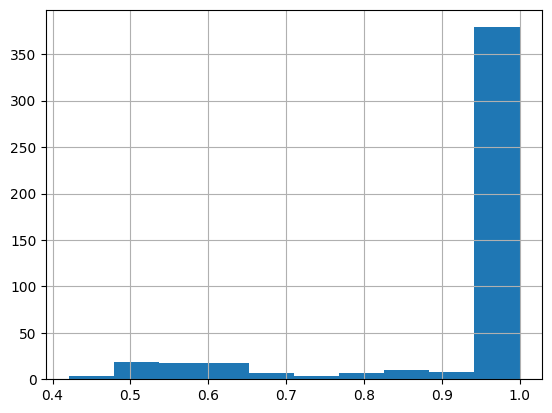

In [36]:


runs_table_df['objectives/OBJ 0-1-1-1 (v0)'].hist()

In [53]:
sns.set_context('talk')

In [80]:
chosen_id = 'RCC-1296'
output_dir = '/Users/jonaheaton/Desktop/viz_april1'
obj_cols = df.columns
for obj_col in obj_cols:
    sns.displot(df[obj_col], bins=25)
    plt.axvline(df.loc[chosen_id][obj_col], color='red', label=chosen_id)
    plt.legend()
    plt.title(obj_col)
    plt.savefig(os.path.join(output_dir, f'{obj_col}.png'))
    plt.close()
